In [2]:
import sys
sys.path.append('../vysxd')
from vysxd_analysis import *
from vysxd_define import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from scipy import *

In [3]:
def density_transform(v: float, t: float, x: np.array):
    gamma = 1/np.sqrt(1-v**2)

    t1 = np.zeros(len(x))+t
    x1 = x

    t2 = gamma*(t1 - v*x1)
    x2 = gamma*(x1 - v*t1)
    return t2,x2

In [4]:
p1x1_files = np.sort(os.listdir('data/MS/PHA/p1x1/electrons/')) # Create a sorted list of filenames you will be analyzing
p1x1_temp = vysxd_get_data(f'data/MS/PHA/p1x1/electrons/{p1x1_files[0]}') # pick out the first timestep for reasons
time_prime, x_prime = density_transform(v=0.10,t=p1x1_temp.TIME[0],x=p1x1_temp.X)
density = -np.trapz(p1x1_temp.DATA, axis=0)

for file in p1x1_files[1:]:
    p1x1 = vysxd_get_data(f'data/MS/PHA/p1x1/electrons/{file}') # Pull the phase space data
    time_prime_temp, x_prime_temp = density_transform(v=0.10,t=p1x1.TIME[0],x=p1x1.X)
    density_temp = -np.trapz(p1x1.DATA, axis=0)

    time_prime = np.vstack((time_prime, time_prime_temp))
    x_prime = np.vstack((x_prime, x_prime_temp))
    density = np.vstack((density, density_temp))

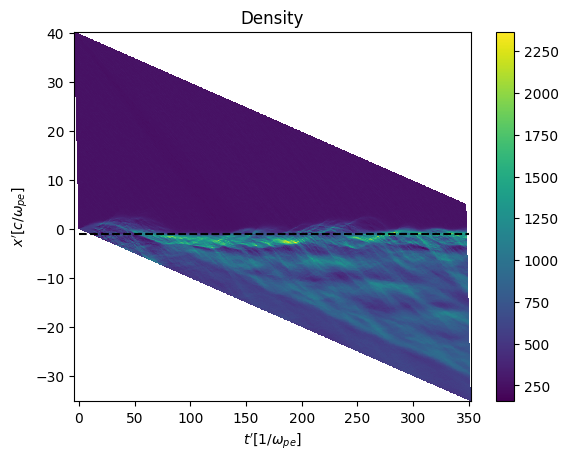

In [5]:
d_min, d_max = np.abs(density).min(), np.abs(density).max()

c = plt.pcolormesh(time_prime,x_prime, density, vmin = d_min, vmax = d_max)
plt.colorbar(c)
plt.ylabel(r'$x^\prime [c/\omega_{pe}]$')
plt.xlabel(r'$t^\prime [1/\omega_{pe}]$')
plt.hlines(-1.0,0,350, colors = 'black', linestyles= '--')
plt.title('Density')
plt.show()

In [59]:
# Integrate over what is constant position in the transformed frame

def line_integrate(quantity, t0, t1, x0, v):
    q_f = interpolate.RegularGridInterpolator([quantity[3],quantity[4]], quantity[0]) # 3rd index stores time axis, 4th stores space axis
    soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)
    return soln[0], soln[1]

def box_integrate(quantity,xmin,xmax,tmin,tmax,v):
    dx = quantity[2]
    xmin_index = int(xmin/dx)
    xmax_index = int(xmax/dx)
    sol = []
    for x in quantity[4][xmin_index:xmax_index]: 
        sol.append(line_integrate(quantity, tmin, tmax, x, v)[0])
    plt.plot(quantity[4][xmin_index:xmax_index], sol)
    plt.xlabel()

In [29]:
## pull data

b1_path = 'data/MS/FLD/part_b1/'
b2_path = 'data/MS/FLD/part_b2/'
b3_path = 'data/MS/FLD/part_b3/'

b1 = get_osiris_quantity_1d(b1_path)
b1_0 = vysxd_get_data(f'{b1_path}part_b1-000000.h5') ##can use this for easy labeling

b2 = get_osiris_quantity_1d(b2_path)
b2_0 = vysxd_get_data(f'{b2_path}part_b2-000000.h5')

b3 = get_osiris_quantity_1d(b3_path)
b3_0 = vysxd_get_data(f'{b3_path}part_b3-000000.h5')


e1_path = 'data/MS/FLD/part_e1/'
e2_path = 'data/MS/FLD/part_e2/'
e3_path = 'data/MS/FLD/part_e3/'

e1 = get_osiris_quantity_1d(e1_path)
e1_0 = vysxd_get_data(f'{e1_path}part_e1-000000.h5') ##can use this for easy labeling

e2 = get_osiris_quantity_1d(e2_path)
e2_0 = vysxd_get_data(f'{e2_path}part_e2-000000.h5')

e3 = get_osiris_quantity_1d(e3_path)
e3_0 = vysxd_get_data(f'{e3_path}part_e3-000000.h5')

density = get_osiris_quantity_1d('data/MS/DENSITY/electrons/charge/')

In [54]:
density_f = interpolate.RegularGridInterpolator([density[3], density[4]], density[0])
# density[3]
density_f([348,20])

array([-1.86222957])

/tmp/ipykernel_245264/1355455182.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)


Text(0.5, 0, 'x position')

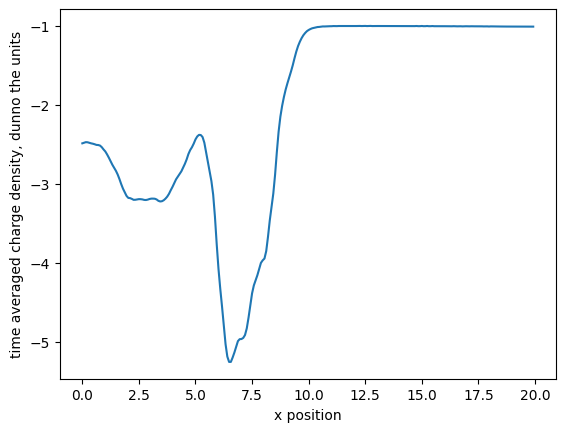

In [64]:
box_integrate(density,0,20,100,200,.10)
plt.ylabel('time averaged charge density, dunno the units')
plt.xlabel('x position')

/tmp/ipykernel_245264/757392588.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)


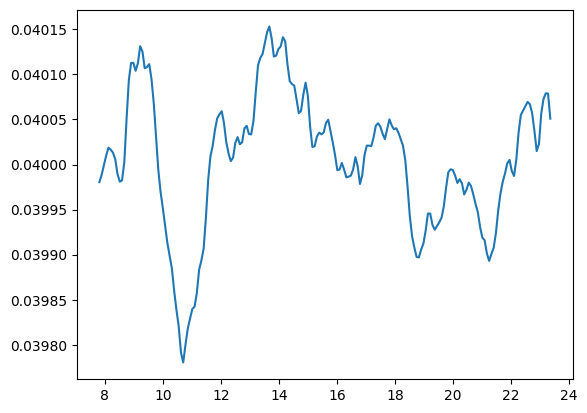

In [41]:
sol = []
for x in b3[4][100:300]: 
    sol.append(box_integrate(b3, 10, 15, x, .1)[0])
plt.plot(b3[4][100:300],sol)

/tmp/ipykernel_245264/757392588.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)
/tmp/ipykernel_245264/757392588.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)


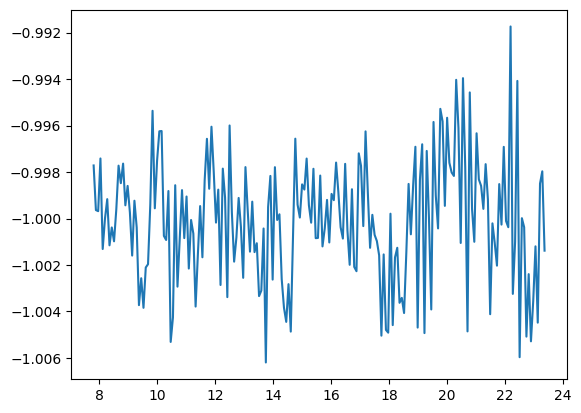

In [42]:
sol = []
for x in density[4][100:300]: 
    sol.append(box_integrate(density, 10, 15, x, .1)[0])
plt.plot(density[4][100:300],sol)

In [46]:

t_axis = e1[3]; x_axis = e1[4]
q_f = interpolate.RegularGridInterpolator([t_axis,x_axis], e1[0])
integrate.quad(lambda x: q_f([x,1]),0,10)

/tmp/ipykernel_5646/2268441045.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(lambda x: q_f([x,1]),0,10)


(-0.019278990324623196, 1.9817632126994944e-07)

In [14]:
sum = integrate.quad(lambda x: x**2,0,10)

In [16]:
sum[0]

333.33333333333326